In [1]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ścieżka zapisywania rysunków
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "R05"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
MY_CONST= 12

    

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)




In [56]:
# przygotowywanie danych
from sklearn.svm import SVC, LinearSVC
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

iris_ds = datasets.load_iris()
X=iris_ds.data[:,(2,3)]
y=iris_ds.target

#selecting only 2 types
iris_versicolor_msk = ((y==0) | (y==1))
y= y[iris_versicolor_msk]
X= X[iris_versicolor_msk]
X_scaled=StandardScaler().fit_transform(X)

X_patlen_setosa=X[:, 0][y==0]
X_patwid_setosa=X[:, 1][y==0]
X_patlen_versi=X[:, 0][y==1]
X_patwid_versi=X[:, 1][y==1]

pipe = Pipeline([
    ('Scaler',StandardScaler()),
    ('SVM',LinearSVC(loss='hinge',C=1))
])


pipe.fit(X,y)
pipe.predict([[5.5,1.2]])



array([1])

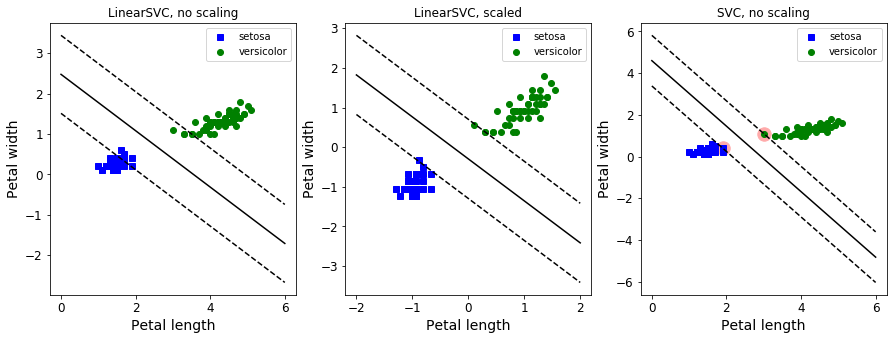

In [68]:
# porownanie modeli 

def plot_boundaries(trainced_model,xmin,xmax):
    # w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    b=trainced_model.intercept_[0]
    w0=trainced_model.coef_[0][0]
    w1=trainced_model.coef_[0][1]
    
    x0 = np.arange(xmin,xmax+0.1,0.1)   #zakladamy jako argument
    x1 = -w0/w1*x0 -b/w1                #to musimy obliczyc
    margin=1/w1

    plt.plot(x0,x1,'k')
    plt.plot(x0,x1-margin,'k--')
    plt.plot(x0,x1+margin,'k--')

def plot_setosa_versicolor(scaled=None,bvectors=None):
    if(scaled is not None):
        X_patlen_setosa=X_scaled[:, 0][y==0]
        X_patwid_setosa=X_scaled[:, 1][y==0]
        X_patlen_versi=X_scaled[:, 0][y==1]
        X_patwid_versi=X_scaled[:, 1][y==1]
    else:
        X_patlen_setosa=X[:, 0][y==0]
        X_patwid_setosa=X[:, 1][y==0]
        X_patlen_versi=X[:, 0][y==1]
        X_patwid_versi=X[:, 1][y==1]

    plt.plot(X_patlen_setosa,X_patwid_setosa,'bs',label='setosa')
    plt.plot(X_patlen_versi,X_patwid_versi,'go',label='versicolor')
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    plt.legend()

    if(bvectors is not None):
        plt.scatter(bvectors[:, 0], bvectors[:, 1], s=180, facecolors='#FFAAAA')

svm_clf_linear = LinearSVC(loss='hinge',C=1);svm_clf_linear.fit(X,y)    #to nie wspiera support_vectors, potrzebne dodatkowe skalowanie 
svm_clf_linear_scaled = LinearSVC(loss='hinge',C=1);svm_clf_linear_scaled.fit(X_scaled,y)    #to nie wspiera support_vectors, potrzebne dodatkowe skalowanie 
svm_clf_SVC = SVC(kernel="linear", C=float('inf'));svm_clf_SVC.fit(X,y)    #to nie wspiera support_vectors, potrzebne dodatkowe skalowanie 

fig, axes = plt.subplots(ncols=3, figsize=(15,5), sharey=False)
plt.sca(axes[0])
plt.title('LinearSVC, no scaling')
plot_setosa_versicolor()
plot_boundaries(svm_clf_linear,0,6)
plt.sca(axes[1])
plt.title('LinearSVC, scaled')
plot_setosa_versicolor(scaled=True)
plot_boundaries(svm_clf_linear_scaled,-2,2)
plt.sca(axes[2])
plt.title('SVC, no scaling')
plot_setosa_versicolor(scaled=None,bvectors=svm_clf_SVC.support_vectors_)
plot_boundaries(svm_clf_SVC,0,6)

#TODO: zobacz co sie stanie jak dorzycisz jakies dane


In [134]:
#wielomiany (make_moons)

from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

if ('X' not in globals()):
    X,y = make_moons(n_samples=100,noise=0.15)
    plt.scatter(X[:,0][y==0],X[:,1][y==0])
    plt.scatter(X[:,0][y==1],X[:,1][y==1])

prepare = Pipeline([
    ('polynomials',PolynomialFeatures(degree=3)),
    ('scaler',StandardScaler())
])
# if('X_sc' not in globals()):
X_sc=prepare.fit_transform(X)
svc_clf = LinearSVC(loss='hinge',C=10)
svc_clf.fit(X_sc,y)
# svc_clf.coef_
# svc_clf.decision_function(X_scaled)


#chyba trzeba podbic to w jakis sposob
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(svc_clf,[-1.5, 2.5, -1, 1.5])


C:\Users\dj6dvj\Anaconda3\envs\tf2\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ValueError: X has 2 features per sample; expecting 10

In [128]:
X_sc[:,10]


IndexError: index 10 is out of bounds for axis 1 with size 10